# Algoritmo Q-learning (paso a paso)

Basado en:
https://www.oreilly.com/learning/introduction-to-reinforcement-learning-and-openai-gym

https://github.com/dennybritz/reinforcement-learning/blob/master/TD/SARSA%20Solution.ipynb

In [1]:
!git clone https://github.com/dennybritz/reinforcement-learning.git

import sys
sys.path.append("/content/reinforcement-learning/")

import pprint
import itertools
from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt
from lib.envs.gridworld import GridworldEnv



Cloning into 'reinforcement-learning'...
remote: Enumerating objects: 1290, done.
remote: Counting objects: 100% (16/16), done.
remote: Compressing objects: 100% (12/12), done.
remote: Total 1290 (delta 5), reused 10 (delta 4), pack-reused 1274
Receiving objects: 100% (1290/1290), 5.25 MiB | 19.77 MiB/s, done.
Resolving deltas: 100% (826/826), done.


### Leer el entorno

Grid World environment from Sutton's Reinforcement Learning book chapter 4. You are an agent on an MxN grid and your goal is to reach the terminal state at the top left or the bottom right corner. For example, a 4x4 grid looks as follows:

    T  o  o  o
    o  x  o  o
    o  o  o  o
    o  o  o  T

`x` is your position and `T` are the two terminal states. You can take actions in each direction (UP=0, RIGHT=1, DOWN=2, LEFT=3).
<br>Actions going off the edge leave you in your current state.
<br>You receive a reward of -1 at each step until you reach a terminal state.

In [2]:
pp = pprint.PrettyPrinter(indent=2)
env = GridworldEnv()
moves = {0: 'Up', 1: 'Right', 2: 'Down', 3: 'Left'}

In [3]:
env._render()

T  o  o  o
o  o  o  o
o  x  o  o
o  o  o  T


### Función que a partir de la observación (estado) devuelve vector de probabilidades.

In [4]:
def make_epsilon_greedy_policy(Q, epsilon, nA):
    """
    Creates an epsilon-greedy policy based on a given Q-function and epsilon.
    
    Args:
        Q: A dictionary that maps from state -> action-values.
            Each value is a numpy array of length nA (see below)
        epsilon: The probability to select a random action. float between 0 and 1.
        nA: Number of actions in the environment.
    
    Returns:
        A function that takes the observation as an argument and returns
        the probabilities for each action in the form of a numpy array of length nA.
    
    """
    def policy_fn(observation):
        A = np.ones(nA, dtype=float) * epsilon / (nA-1)
        best_action = np.argmax(Q[observation])
        A[best_action] = (1.0 - epsilon)
        return A
    return policy_fn

### Q-LEARNING

In [5]:
def q_learning(env, num_episodes, discount_factor=1.0, alpha=0.5, epsilon=0.1):
    """
    Q-Learning algorithm: Off-policy TD control. Finds the optimal greedy policy
    while following an epsilon-greedy policy
    
    Args:
        env: OpenAI environment.
        num_episodes: Number of episodes to run for.
        discount_factor: Gamma discount factor.
        alpha: TD learning rate.
        epsilon: Chance the sample a random action. Float betwen 0 and 1.
    
    Returns:
        A tuple (Q, episode_lengths).
        Q is the optimal action-value function, a dictionary mapping state -> action values.
        stats is an EpisodeStats object with two numpy arrays for episode_lengths and episode_rewards.
    """
    
    # The final action-value function.
    # A nested dictionary that maps state -> (action -> action-value).
    Q = defaultdict(lambda: np.zeros(env.action_space.n))

    # Keeps track of useful statistics
    episode_lengths = np.zeros(num_episodes)
    episode_rewards = np.zeros(num_episodes)   
    
    # The policy we're following
    policy = make_epsilon_greedy_policy(Q, epsilon, env.action_space.n)
    
    for i_episode in range(num_episodes):
        # Print out which episode we're on, useful for debugging.
        if (i_episode + 1) % 100 == 0:
            print("\rEpisode {}/{}.".format(i_episode + 1, num_episodes), end="")
            sys.stdout.flush()
        
        # Reset the environment and pick the first action
        state = env.reset()
        
        # One step in the environment
        # total_reward = 0.0
        for t in itertools.count():
            # Take a step
            action_probs = policy(state)
            action = np.random.choice(np.arange(len(action_probs)), p=action_probs)
            next_state, reward, done, _ = env.step(action)

            # Update statistics
            episode_rewards[i_episode] += reward
            episode_lengths[i_episode] = t
            
            # TD Update
            best_next_action = np.argmax(Q[next_state])    
            td_target = reward + discount_factor * Q[next_state][best_next_action]
            td_delta = td_target - Q[state][action]
            Q[state][action] += alpha * td_delta
                
            if done:
                break
                
            state = next_state
    
    return Q, episode_lengths, episode_rewards

## Paso a paso

In [6]:
# Parametros
discount_factor = 1.0
alpha = 0.5
epsilon = 0.1

In [7]:
# Inicializamos
Q = defaultdict(lambda: np.zeros(env.action_space.n)) 
# The policy we're following
policy = make_epsilon_greedy_policy(Q, epsilon, env.action_space.n)
# Reset the environment and pick the first action
state = env.reset()

EMPEZAMOS A ENTRENAR

In [8]:
env._render()

T  o  o  o
x  o  o  o
o  o  o  o
o  o  o  T


In [9]:
# Valores en el estado actual
print(state, Q[state])

4 [0. 0. 0. 0.]


In [10]:
 # Probabilidades de tomar cada accion
action_probs = policy(state)
print(action_probs)

[0.9        0.03333333 0.03333333 0.03333333]


In [11]:
# Elegimos la acción usando un "dado pesado por las probabilidades"
action = np.random.choice(np.arange(len(action_probs)), p=action_probs)
print(action, "=>", moves[action])

0 => Up


In [12]:
# Hacemos la acción y vemos el resultado
next_state, reward, done, _ = env.step(action)
print(next_state)
print(reward)
print(done)

0
-1.0
True


In [13]:
env._render()

x  o  o  o
o  o  o  o
o  o  o  o
o  o  o  T


In [14]:
# Mejor acción a futuro
best_next_action = np.argmax(Q[next_state])
print(Q[next_state], "=>", best_next_action, "=>", moves[best_next_action])

[0. 0. 0. 0.] => 0 => Up


Actualizamos aplicando la ecuación de Bellman:
$Q(S_t,A_t)=Q(S_t,A_t) + \alpha[R_{t+1} + \gamma\max_a{Q(S_{t+1}},a) - Q(S_t,A_t)]$.

In [15]:
# Aplicamos la actualización aplicando la ecuación de Bellman
print('antes:', state, Q[state])
td_target = reward + discount_factor * Q[next_state][best_next_action]
print('td target:', td_target)
td_delta = td_target - Q[state][action]
print('td delta:', td_delta)
Q[state][action] = Q[state][action] + alpha * td_delta
print('despues de actualizar:', state, Q[state])

antes: 4 [0. 0. 0. 0.]
td target: -1.0
td delta: -1.0
despues de actualizar: 4 [-0.5  0.   0.   0. ]


In [16]:
# Tabla Q states x action after updating
Q

defaultdict(<function __main__.<lambda>()>,
            {4: array([-0.5,  0. ,  0. ,  0. ]), 0: array([0., 0., 0., 0.])})

Ejecutamos el algoritmo en 200 episodios (que no 200 veces)

In [17]:
Q, stats_episode_lengths, stats_episode_rewards = q_learning(env, 200)

Episode 200/200.

Visualizamos cuanto duran los episodios conforme aprende.
<br>Cada vez duran menos, ¿por qué?

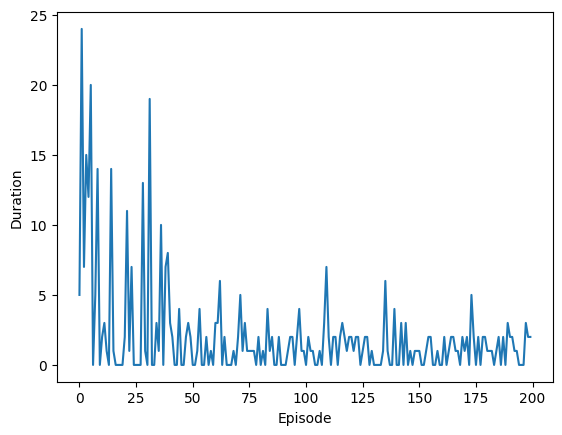

In [18]:
plt.plot(stats_episode_lengths)
plt.xlabel('Episode')
plt.ylabel('Duration');

Visualizamos las recompensas por episodio

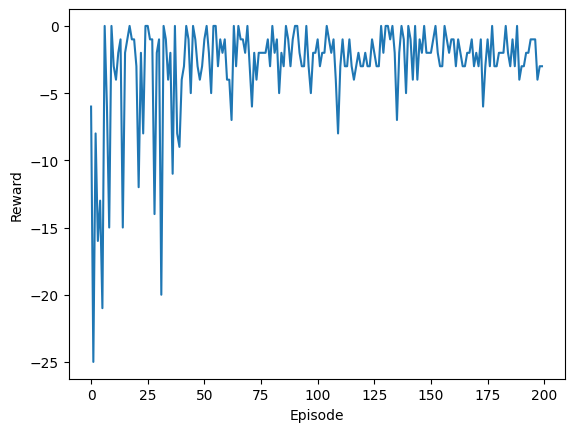

In [19]:
plt.plot(stats_episode_rewards)
plt.xlabel('Episode')
plt.ylabel('Reward');

Matriz Q de estados x acciones

In [20]:
for i in range(16):
    print(i, np.round(Q[i], 4))

0 [0. 0. 0. 0.]
1 [-1.     -2.3736 -2.4017 -1.    ]
2 [-2.6038 -2.8799 -2.2812 -2.    ]
3 [-3.5851 -3.3672 -2.994  -2.9801]
4 [-1.     -2.4803 -2.5234 -1.75  ]
5 [-1.999  -2.125  -2.9306 -1.9991]
6 [-2.8973 -2.922  -2.8969 -2.9093]
7 [-3.5254 -2.8087 -2.     -2.0938]
8 [-2.     -2.2812 -2.     -2.2656]
9 [-2.8984 -2.8823 -2.8278 -2.8875]
10 [-2.2812 -1.9991 -1.9983 -2.5698]
11 [-1.7812 -1.75   -1.     -1.375 ]
12 [-2.9531 -2.9526 -3.25   -3.4061]
13 [-2.3906 -2.     -2.746  -2.    ]
14 [-2.7057 -1.     -1.5    -2.8688]
15 [0. 0. 0. 0.]


Echamos unas partidas a ver ...

In [21]:
total_reward = 0
state = env.reset()
env._render(); print("")
for i in range(100):
    action = np.argmax(Q[state]) #1
    state, reward, done, info = env.step(action) #2
    total_reward += reward
    env._render(); print("")
    if done:
        break

print("Episodes", i+1, "total reward", total_reward)

T  o  o  o
o  o  o  o
o  o  o  o
o  x  o  T

T  o  o  o
o  o  o  o
o  o  o  o
o  o  x  T

T  o  o  o
o  o  o  o
o  o  o  o
o  o  o  x

Episodes 2 total reward -2.0
